In [1]:
import random
from time import time
import cvxpy as cvx
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from scipy.sparse import linalg

%matplotlib inline

In [2]:
features, targets = load_svmlight_file('usps')
targets = np.array(list(map(int, targets))) - 1
features = np.array(features.todense())

num_examples, feature_dim = features.shape

In [4]:
def f_i(features, targets, w, i):
    target_i = targets[i]
    return np.log(np.sum(np.exp(w@features[i]))) - w[target_i]@features[i]
    
def result_function(features, targets, w):
    loss = 0
    n_examples = targets.shape[0]
    
    for i in range(n_examples):
        loss += f_i(features, targets, w, i)
    return loss/n_examples

def grad_i(features, targets, w, i):
    exp = np.exp(w@features[i].T)
    grad = np.outer(exp/np.sum(exp),features[i])
    grad[targets[i]] -= - features[i]
    return grad

def grad(features, targets, w, stochastic=False, batch_size=50):
    n_examples = targets.shape[0]
    gradient = np.zeros_like(w)
    if stochastic:
        rand_index = np.random.randint(0, n_examples-1, size=batch_size)
        for i in rand_index:
            gradient += grad_i(features, targets, w, i)
        return gradient/batch_size
    else:
        for i in range(n_examples):
            gradient += grad_i(features, targets, w, i)
        return gradient/n_examples

In [5]:
def SFW_step(w_k, k, gradient):
    u, s, vt = linalg.svds(gradient, 1)
    v_k = -50*u@vt
    gamma = 2./(k + 2.)
    w_k = (1 - gamma)*w_k + gamma*v_k
    return w_k

In [6]:
start_time = time()
step=0
losses, times = [], [0]
w = np.load('losses/w.npy')[0]
loss = result_function(features, targets, w)
losses.append(loss)
times.append(round(time() - start_time, 2))

for step in tqdm(range(250)):
    gradient = grad(features, targets, w, stochastic=True)
    w = SFW_step(w, step+1, gradient)
    loss = result_function(features, targets, w)
    losses.append(loss)
    times.append(round(time() - start_time, 2))

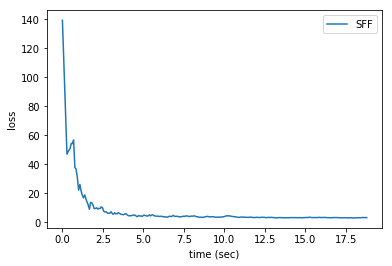

In [7]:
plt.plot(times[:-1], losses, label = 'SFF')
plt.xlabel('time (sec)')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
np.save('losses/losses_SFF', losses)
np.save('losses/times_SFF', times[:-1])